In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer as stemmer
import string
import numpy as np 
from collections import Counter 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import re
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import os
from sklearn.decomposition import NMF
from nltk.corpus import wordnet
from termcolor import colored
import gensim
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from gensim.utils import simple_preprocess
import spacy


In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None) 

In [3]:
%cd Desktop

C:\Users\VIJESH\Desktop


In [4]:
bangalore_data=pd.read_csv("doctor_Bangalore.csv")
delhi_data=pd.read_csv("doctor_Delhi.csv")
mumbai_data=pd.read_csv("doctor_Mumbai.csv")

In [5]:
data=pd.concat([bangalore_data,delhi_data,mumbai_data]) #merging all the reviews

In [6]:
len(data) #total length of the data

14665

In [7]:
data.head()

,reviews,recommendation,location
0,This doctor is so to the point and focused and she asked all the right questions right from the go. Her tone is very accommodating. I am impressed.,I recommend the doctor,Bangalore
1,*** ** *** **** ****** ** ********** ***** She explains the issue in our body and tells us how to solve it rather than just prescribing medicine. I recommend her,I recommend the doctor,Bangalore
2,Doctor listened very patiently and explained everything. She advised me medicine. I got little releif. But overall my experience is good with doctor. Thanks Doctor,I recommend the doctor,Bangalore
3,such a wonderfull doctor who explains clearly *** *** **** * ***** **********I am perfectly alright now ..😊,I recommend the doctor,Bangalore
4,Even after booking through practo we had to wait for other patients and they charged extra on top of it. Seriously I don't understand the need of booking through practo . I would never recommend this app to anyone. It's better to go directly and save some money.,I do not recommend the doctor,Bangalore


In [8]:
data['reviews']=data['reviews'].astype(str) #converts the datatype of the reviews to string

## Setting up the stopwords

In [9]:
stop_list = stopwords.words('english')+['us']
not_stopwords = {'do','does','could','did','had','will','not',"didn't","doesn't","don't","couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"} 
stop_list = set([word for word in stop_list if word not in not_stopwords])
#as few stop words will be useful in our analysis ,those are excluded from the stoplist

In [10]:
len(stop_list)

142

## Function to clean the text

In [11]:
def clean(row):
    s=row['reviews']
    word=s.split()
    word = [w for w in word if not w in stop_list]    #words passes this ,only if the words are not in stopwords
    word=' '.join(word)
    lmtzr = nltk.WordNetLemmatizer().lemmatize   


    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ          #returns the root form of the adjective
        elif treebank_tag.startswith('V'):
            return wordnet.VERB         #returns the root form of the verb
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN          #returns the root form of the noun
        elif treebank_tag.startswith('R'):
            return wordnet.ADV           #returns the root form of the adverb
        else:
            return wordnet.NOUN


    def normalize_text(text):
        word_pos = nltk.pos_tag(nltk.word_tokenize(text)) #tags the word as adjective or noun or verb or adverb
        lemm_words = ' '.join(lmtzr(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos) #calls function and lemmatizes the word

        return lemm_words

    word=normalize_text(word) #calls the function
    word=word.split()
    word=[lemmatizer.lemmatize(token,'v') for token in word]
    review=' '.join(word)
    string.punctuation='!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~' 
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #removes all the puncuation
    clean=review.translate(translator)
    cleaned=re.sub(' +',' ',clean)   #removes all extra spaces
    return(cleaned)

In [12]:
data['text_clean']=data.apply(lambda row:clean(row),axis=1) #calling function

In [13]:
data=data.dropna(how='any')  #drops all missing reviews

In [14]:
data.head(5)

,reviews,recommendation,location,text_clean
0,This doctor is so to the point and focused and she asked all the right questions right from the go. Her tone is very accommodating. I am impressed.,I recommend the doctor,Bangalore,This doctor point focus ask right question right go Her tone accommodate I impress
1,*** ** *** **** ****** ** ********** ***** She explains the issue in our body and tells us how to solve it rather than just prescribing medicine. I recommend her,I recommend the doctor,Bangalore,She explain issue body tell solve rather prescribe medicine I recommend
2,Doctor listened very patiently and explained everything. She advised me medicine. I got little releif. But overall my experience is good with doctor. Thanks Doctor,I recommend the doctor,Bangalore,Doctor listen patiently explain everything She advise medicine I get little releif But overall experience good doctor Thanks Doctor
3,such a wonderfull doctor who explains clearly *** *** **** * ***** **********I am perfectly alright now ..😊,I recommend the doctor,Bangalore,wonderfull doctor explain clearly I perfectly alright 😊
4,Even after booking through practo we had to wait for other patients and they charged extra on top of it. Seriously I don't understand the need of booking through practo . I would never recommend this app to anyone. It's better to go directly and save some money.,I do not recommend the doctor,Bangalore,Even book practo have wait patient charge extra top it Seriously I do n't understand need book practo I would never recommend app anyone It 's good go directly save money


In [15]:
def remove_stop_words(raw_text, stop_list):
    raw_text=raw_text.lower()
    raw_text=raw_text.replace(" n't",'not')
    raw_text=raw_text.replace(" not",'not')
    words = raw_text.split()
    word = [w for w in words if not w in stop_list]
    review=' '.join(word)
    cleaned=re.sub(' +',' ',review)
    return(cleaned)

## function to perform LDA Topic Modelling

In [16]:
def topics(List):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer.fit(List)
    counts = count_vectorizer.transform(List).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    lda = models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=1)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,passes=10,alpha='auto',per_word_topics=True)
    return lda.print_topics()
    

## Function to classify the positive and negative reviews

In [17]:
def sentiment_scores(recom): 
 
    if  recom =='I recommend the doctor' : 
        return "Positive"
    else :
        return "Negative"


In [18]:
data['sentiment']=data.apply(lambda row:sentiment_scores(row['recommendation']),axis=1) #calling function

## First LDA

In [19]:
topics(data['text_clean']) 

[(0,
  '0.049*"doctor" + 0.028*"good" + 0.020*"problem" + 0.019*"dr" + 0.016*"treatment" + 0.016*"patient" + 0.012*"explain" + 0.009*"visit" + 0.008*"friendly" + 0.007*"recommend"'),
 (1,
  '0.032*"dr" + 0.030*"problem" + 0.027*"doctor" + 0.024*"patient" + 0.017*"friendly" + 0.017*"time" + 0.016*"treatment" + 0.016*"medicine" + 0.013*"recommend" + 0.013*"good"'),
 (2,
  '0.038*"doctor" + 0.021*"medicine" + 0.020*"explain" + 0.019*"visit" + 0.016*"problem" + 0.015*"dr" + 0.015*"time" + 0.015*"listen" + 0.015*"treatment" + 0.013*"friendly"'),
 (3,
  '0.031*"doctor" + 0.026*"dr" + 0.020*"time" + 0.017*"treatment" + 0.015*"good" + 0.015*"problem" + 0.014*"explain" + 0.013*"patient" + 0.010*"experience" + 0.008*"recommend"'),
 (4,
  '0.045*"doctor" + 0.035*"good" + 0.023*"dr" + 0.021*"experience" + 0.020*"treatment" + 0.015*"nice" + 0.014*"time" + 0.010*"hospital" + 0.010*"problem" + 0.010*"explain"'),
 (5,
  '0.067*"doctor" + 0.038*"good" + 0.030*"patient" + 0.025*"experience" + 0.016*"pro

In [20]:
data['reviews_stop_words'] = data['text_clean'].apply(remove_stop_words, stop_list=stop_list) 

## updating the stopword

In [21]:
extra_stopwords=['nan', 'doctor', "'s",'dr','patient','recommend','recommendation','good','experience','would','like','patients','even','though','problem']
stop_list.update(extra_stopwords)
len(stop_list)

157

In [22]:
data['reviews_stop_words_1'] = data['reviews_stop_words'].apply(remove_stop_words, stop_list=stop_list) 

In [23]:
data.to_csv('processed_reviews_practo.csv',index=False) #saving the processed reviews as a CSV

## Second LDA Topic Modelling

In [24]:
topics(data['reviews_stop_words_1'])

[(0,
  '0.014*"time" + 0.012*"nice" + 0.010*"treatment" + 0.010*"listen" + 0.010*"come" + 0.009*"friendly" + 0.009*"meet" + 0.008*"medicine" + 0.008*"explain" + 0.007*"day"'),
 (1,
  '0.022*"visit" + 0.018*"explain" + 0.018*"medicine" + 0.014*"test" + 0.013*"treatment" + 0.012*"time" + 0.010*"day" + 0.010*"friendly" + 0.009*"donot" + 0.009*"suggest"'),
 (2,
  '0.020*"time" + 0.018*"visit" + 0.018*"treatment" + 0.017*"explain" + 0.014*"listen" + 0.010*"understand" + 0.010*"issue" + 0.009*"clinic" + 0.009*"donot" + 0.009*"test"'),
 (3,
  '0.020*"time" + 0.013*"issue" + 0.013*"medicine" + 0.012*"clinic" + 0.011*"listen" + 0.011*"explain" + 0.010*"visit" + 0.009*"friendly" + 0.008*"health" + 0.008*"consult"'),
 (4,
  '0.030*"treatment" + 0.024*"medicine" + 0.019*"friendly" + 0.017*"listen" + 0.012*"time" + 0.011*"issue" + 0.011*"visit" + 0.011*"explain" + 0.010*"prescribe" + 0.008*"great"'),
 (5,
  '0.016*"time" + 0.013*"listen" + 0.012*"explain" + 0.011*"treatment" + 0.011*"medicine" + 0.

In [25]:
data.head(5)

,reviews,recommendation,location,text_clean,sentiment,reviews_stop_words,reviews_stop_words_1
0,This doctor is so to the point and focused and she asked all the right questions right from the go. Her tone is very accommodating. I am impressed.,I recommend the doctor,Bangalore,This doctor point focus ask right question right go Her tone accommodate I impress,Positive,doctor point focus ask right question right go tone accommodate impress,point focus ask right question right go tone accommodate impress
1,*** ** *** **** ****** ** ********** ***** She explains the issue in our body and tells us how to solve it rather than just prescribing medicine. I recommend her,I recommend the doctor,Bangalore,She explain issue body tell solve rather prescribe medicine I recommend,Positive,explain issue body tell solve rather prescribe medicine recommend,explain issue body tell solve rather prescribe medicine
2,Doctor listened very patiently and explained everything. She advised me medicine. I got little releif. But overall my experience is good with doctor. Thanks Doctor,I recommend the doctor,Bangalore,Doctor listen patiently explain everything She advise medicine I get little releif But overall experience good doctor Thanks Doctor,Positive,doctor listen patiently explain everything advise medicine get little releif overall experience good doctor thanks doctor,listen patiently explain everything advise medicine get little releif overall thanks
3,such a wonderfull doctor who explains clearly *** *** **** * ***** **********I am perfectly alright now ..😊,I recommend the doctor,Bangalore,wonderfull doctor explain clearly I perfectly alright 😊,Positive,wonderfull doctor explain clearly perfectly alright 😊,wonderfull explain clearly perfectly alright 😊
4,Even after booking through practo we had to wait for other patients and they charged extra on top of it. Seriously I don't understand the need of booking through practo . I would never recommend this app to anyone. It's better to go directly and save some money.,I do not recommend the doctor,Bangalore,Even book practo have wait patient charge extra top it Seriously I do n't understand need book practo I would never recommend app anyone It 's good go directly save money,Negative,even book practo wait patient charge extra top seriously donot understand need book practo would never recommend app anyone 's good go directly save money,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money


In [26]:
positive_reviews=data.loc[data['sentiment']=='Positive','reviews_stop_words_1'].tolist()#list of positive reviews
negative_reviews=data.loc[data['sentiment']=='Negative','reviews_stop_words_1'].tolist()#list of negative reviews

In [27]:
def commonwords(review,top):
    reviews=" ".join(review)
    tokenised_reviews=reviews.split(" ")
    
    
    freq_counter=Counter(tokenised_reviews) #counts the occurance
    return freq_counter.most_common(top)

In [28]:
top_30_positive_review_words=commonwords(positive_reviews,30) #top 30 positive reviews
top_30_negative_review_words=commonwords(negative_reviews,30) #top 30 negative reviews

In [29]:
def plotCommonWords(reviews,top,title="Positive Review",color="blue",axis=None):
    top_words=commonwords(reviews,top=top)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(top))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(top))

In [30]:
def generateNGram(text,n):
    text=re.sub(' +',' ',text)
    tokens = [token for token in text.split(" ") if token != ""]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams] #joins two consecutive words

In [31]:
positive_review_bigrams=[" ".join(generateNGram(review,3)) for review in positive_reviews] #positive  bigrams
negative_review_bigrams=[" ".join(generateNGram(review,3)) for review in negative_reviews] #negative bigrams

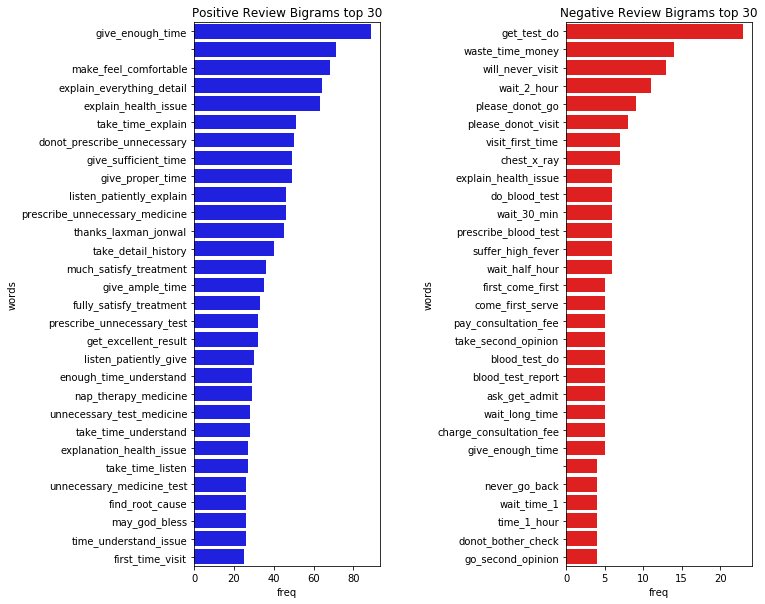

In [32]:
rcParams['figure.figsize'] = 10,10
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1) #Adjusts the space between the two plots
plotCommonWords(positive_review_bigrams,30,"Positive Review Bigrams",axis=ax[0])

plotCommonWords(negative_review_bigrams,30,"Negative Review Bigrams",color="red",axis=ax[1])

## Common words

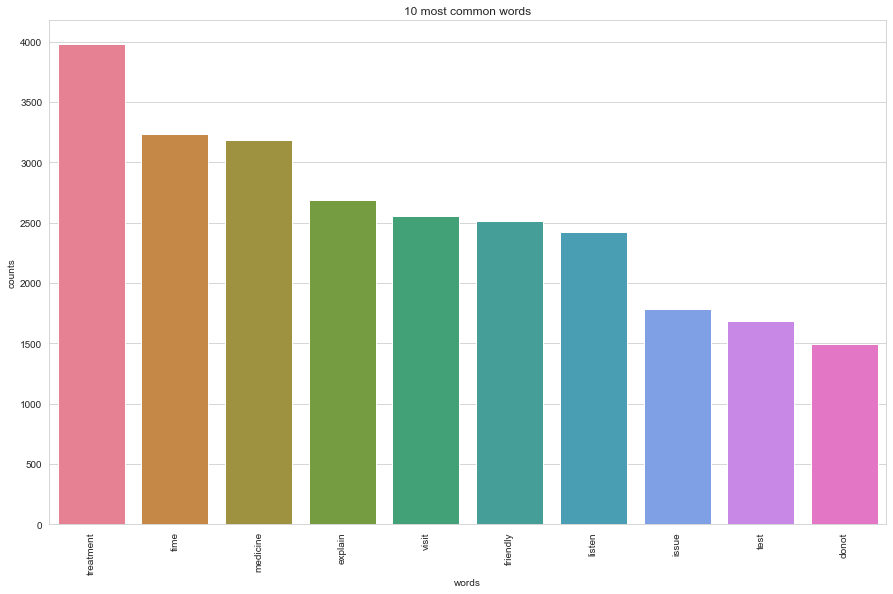

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data['reviews_stop_words_1'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [34]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print(colored("Topics found via LDA:",'green'))
print_topics(lda, count_vectorizer, number_words)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=number_topics)
nmf_model.fit(count_data)
print('\n')
print (colored("Topics found via nmf_Z:",'green'))
print_topics(nmf_model, count_vectorizer, number_words)

print('\n')
print (colored("Topics found via lsi_Z:",'green'))
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=number_topics)
lsi_Z = lsi_model.fit(count_data)
print_topics(lsi_Z, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
time wait donot appointment test visit ask consultation medicine clinic hour come say tell practo fee day charge minute hospital book bad available prescribe make money report need pay min

Topic #1:
listen explain medicine friendly patiently prescribe medication understand time issue treatment nice carefully suggest diagnosis visit feel advise polite make question hear patience highly help really helpful best overall great

Topic #2:
hospital treatment day visit clinic medicine blood sugar come thank tell mother father say really staff report test donot high level meet ask great care fever diabetes happy check control

Topic #3:
treatment friendly explain time issue health understand family medicine satisfy visit treat care test really way happy excellent great highly year cause nice person best unnecessary make diagnosis suggest donot

Topic #4:
treatment medicine visit day pain result suffer fever thanks relief thank month clinic cough treat feel lax

In [35]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(data['reviews_stop_words_1'])

lsa = TruncatedSVD(100, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=10, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

for cluster in range(10):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

time
explain
understand
treat
care
nice
great
really
medication
thank


Cluster 1

wait
appointment
time
wait time
hour
book
come
donot
practo
clinic


Cluster 2

listen
patiently
listen patiently
explain
patiently listen
time
patience
patiently explain
medication
friendly listen


Cluster 3

treatment
satisfy
satisfy treatment
happy
explain
time
thank
happy treatment
diagnosis
nice


Cluster 4

medicine
prescribe
prescribe medicine
day
donot
explain
time
listen
suggest
medicine prescribe


Cluster 5

issue
health
health issue
explain
explain issue
friendly
understand
time
treatment
listen


Cluster 6

visit
time
clinic
treatment
day
medicine
say
year
feel
donot


Cluster 7

friendly
explain
treatment
friendly explain
nature
time
nice
understand
friendly listen
polite


Cluster 8

carefully
listen carefully
listen
medicine
listens
friendly
time
treatment
explain
nice


Cluster 9

test
unnecessary
unnecessary test
report
donot
medicine
blood
suggest
ask
prescribe


